In [77]:
from sklearn import feature_extraction
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
sns.set()
%matplotlib inline

## Text Processing

In [78]:
bible = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/bible_asv.csv")
bible.head()
import string
bible['text']= bible['text'].str.lower()
bible['text'] = bible['text'].str.replace('[^\w\s]','')
bible['text'] = bible['text'].str.replace('\d+', '')
bible['text'] = bible['text'].str.strip(' ')
text = bible['text']
words = text.str.split(' ')
bible.head()

,Unnamed: 0,field,Testaments,Sections,Books,Chapters,Verses,text
0,1,1001001,OT,Law,gen,gen_1,gen_1:1,in the beginning god created the heavens and t...
1,2,1001002,OT,Law,gen,gen_1,gen_1:2,and the earth was waste and void and darkness ...
2,3,1001003,OT,Law,gen,gen_1,gen_1:3,and god said let there be light and there was ...
3,4,1001004,OT,Law,gen,gen_1,gen_1:4,and god saw the light that it was good and god...
4,5,1001005,OT,Law,gen,gen_1,gen_1:5,and god called the light day and the darkness ...


In [79]:
# Create a lone list of words in the bible, in order of narrative time
bible2 = []
for verse in range(len(words)):
    bible2.append(words.iloc[verse,])
    
def iterFlatten(root):
    if isinstance(root, (list, tuple)):
        for element in root:
            for e in iterFlatten(element):
                yield e
    else:
        yield root
        
bible3 = list(iterFlatten(bible2))

## Text Visualization

Number of unique words in the bible :  12654


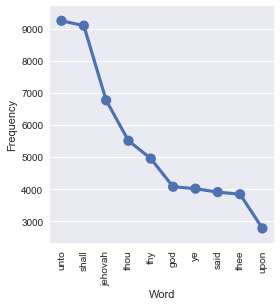

In [80]:
#Count the frequency of each word
from collections import Counter
#Word Frequency
counts = Counter(bible3)
#Convert counter object to data frame
word_count = pd.DataFrame.from_dict(counts, orient='index').reset_index()
word_count.rename(columns = {'index' : 'Word',0:'Frequency'},inplace = True)
word_count = word_count.sort_values('Frequency',ascending=False)
stop = set(stopwords.words('english'))
#Remove stop words from the dataframe
word_count2 = word_count[~word_count['Word'].isin(stop)]
word_count2.head()
#Number of unique words
print("Number of unique words in the bible : ", len(word_count2))
#Top ten words
word_count2.head(10)
#Plot top 10 words after removing stop words
g = sns.factorplot(x='Word',y='Frequency',data=word_count2[0:10])
g.set_xticklabels(rotation=90)
plt.show()

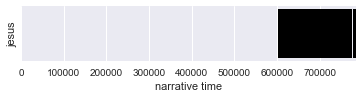

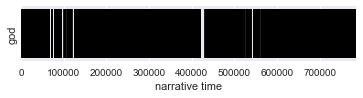

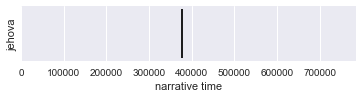

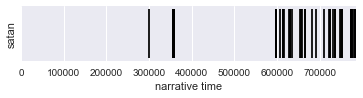

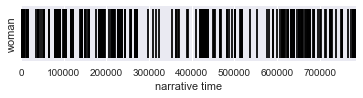

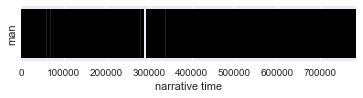

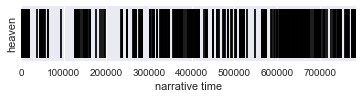

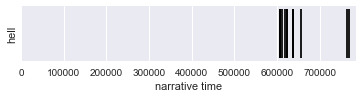

In [83]:
#Function to plot a dispersion graph
def dispersion(word):
    d = list()
    for i in range(0,len(bible3)):
        if bible3[i] == word:
            d.append(i)

    fig, ax = plt.subplots()
    ax.vlines(d, 0, 1, edgecolor="black")
    ax.set_xlim([0, len(bible3)]) # set the lower and upper limits of graph
    ax.set_xlabel('narrative time')
    ax.set_xticks([0],minor=True) # turn off: ax.set_xticks([])
    ax.set_ylabel(word) # turn off by droping this line
    ax.set_yticks([])
    fig.set_figheight(1)
    plt.show()

words_of_interest = ['jesus','god','jehova','satan','woman','man','heaven','hell']
for i in words_of_interest:
    #Dispersion plot words
    dispersion(i)

The figures above show the ocurance of words in the biblical timeline. There are some really interesting things going on here. For one, I find it interesting that "Jesus" only occurs in the last quater of the bible timeline. I also thought the difference in frequency of "woman" and "man" is interesting. 

In [84]:
#Vectorizes text feature using term frequency-inverse document frequency 
vec = feature_extraction.text.TfidfVectorizer(stop_words = 'english',token_pattern=r'(?u)\b[A-Za-z]+\b', max_features=10000)
X = vec.fit_transform(bible['text'].values.astype('str'))
feature_names = vec.get_feature_names()
text = pd.DataFrame(X.toarray(), columns=feature_names)

# merge vectorized columns with original dataframe
bible_vec = pd.merge(bible, text, left_index=True, right_index=True)
bible_vec = bible_vec.drop(['text'],axis = 1)
bible_vec.head()

,Unnamed: 0,field_x,Testaments,Sections,Books,Chapters,Verses,aaron,aarons,abaddon,...,zophar,zophim,zorah,zorathites,zorites,zuar,zuph,zur,zuriel,zurishaddai
0,1,1001001,OT,Law,gen,gen_1,gen_1:1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1001002,OT,Law,gen,gen_1,gen_1:2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1001003,OT,Law,gen,gen_1,gen_1:3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1001004,OT,Law,gen,gen_1,gen_1:4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1001005,OT,Law,gen,gen_1,gen_1:5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# The dataset is now vectorized and ready for analysis.
X = bible_vec.drop(['Unnamed: 0','field_x','Testaments','Sections','Books','Chapters','Verses'],axis=1)
X.head()

,aaron,aarons,abaddon,abagtha,abanah,abarim,abase,abased,abasing,abated,...,zophar,zophim,zorah,zorathites,zorites,zuar,zuph,zur,zuriel,zurishaddai
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PCA

In [86]:
# keep the first n principal components of the data
pca = PCA(n_components=100)
# fit PCA model to data
pca.fit(X)

# transform data onto the first two principal components
X_pca = pca.transform(X)
print("Original shape: {}".format(X.shape))
print("Reduced shape: {}".format(X_pca.shape))

Original shape: (31103, 10000)
Reduced shape: (31103, 100)


Text(0,0.5,'Second principal component')

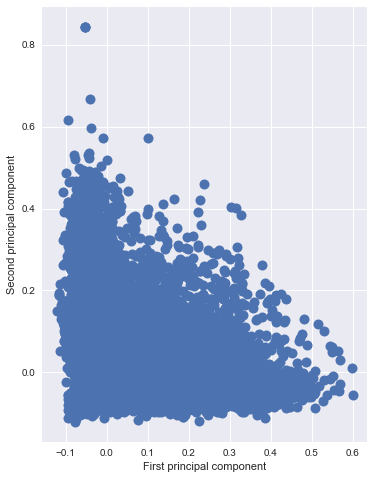

In [87]:
# plot first vs. second principal component
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1])
#plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

## Part A: Cluster Visualization

In [88]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
clust = ['Kmeans','Hierarchal','Gaussian Mixture']

Text(0,0.5,'PC2')

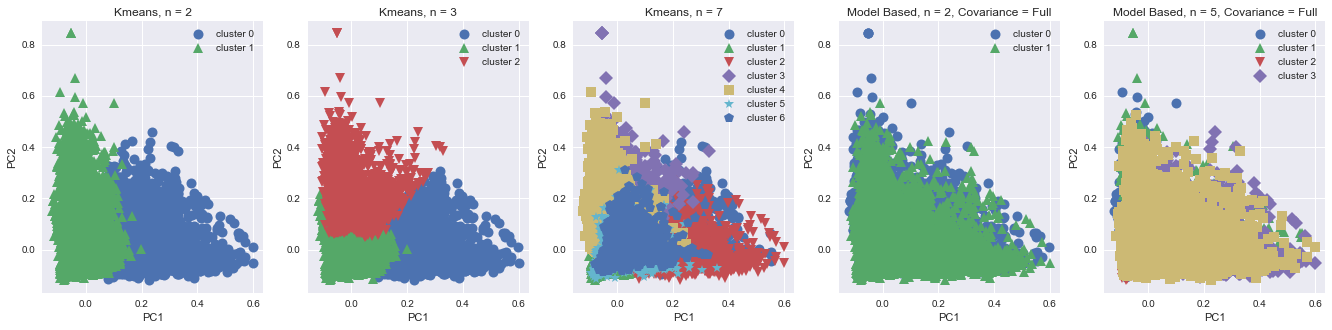

In [89]:
# Here I compare Kmeans with varying clusters and Model Based clustering with varying clusters. 
fig, axes = plt.subplots(1, 5, figsize=(23,5))

# Kmeans:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)
assignments = kmeans.labels_
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignments, ax=axes[0])
ax = axes[0]
ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3","cluster 4","cluster 5", "cluster 6", "cluster 7"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('Kmeans, n = 2')
ax.set_ylabel('PC2')


# Kmeans:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_pca)
assignments = kmeans.labels_
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignments, ax=axes[1])
ax = axes[1]
ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3","cluster 4","cluster 5", "cluster 6", "cluster 7"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('Kmeans, n = 3')
ax.set_ylabel('PC2')

# Kmeans:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_pca)
assignments = kmeans.labels_
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignments, ax=axes[2])
ax = axes[2]
ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3","cluster 4","cluster 5", "cluster 6", "cluster 7"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('Kmeans, n = 7')
ax.set_ylabel('PC2')

# Model Based:
gmm = GaussianMixture(n_components=2, covariance_type='full').fit(X_pca)
assignments =gmm.predict(X_pca)
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignments, ax=axes[3])
ax = axes[3]
ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('Model Based, n = 2, Covariance = Full')
ax.set_ylabel('PC2')

# Model Based:
gmm = GaussianMixture(n_components=5, covariance_type='full').fit(X_pca)
assignments =gmm.predict(X_pca)
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], assignments, ax=axes[4])
ax = axes[4]
ax.legend(["cluster 0", "cluster 1", "cluster 2","cluster 3"], loc='upper right')
ax.set_xlabel('PC1')
ax.set_title('Model Based, n = 5, Covariance = Full')
ax.set_ylabel('PC2')

In theory, the plots below should give us a visualization of the two testaments (n = 2) and the 7 books (n = 7) of the bible. 

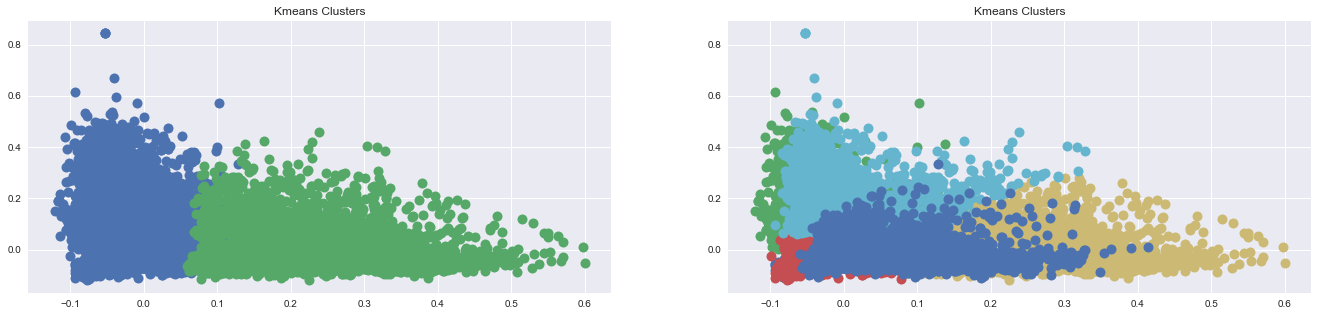

In [90]:
plt.figure(figsize=(23,5))

plt.subplot(121)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], kmeans.labels_, markers='o')
plt.title('{:} Clusters'.format(clust[0]));

plt.subplot(122)
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_pca)
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], kmeans.labels_, markers='o')
plt.title('{:} Clusters'.format(clust[0]));
#fig2=sns.relplot(x="PCA0", y="PCA1", data=X_pca, hue="Testament", size='Section', style='Testa', legend='full', palette= 'Set2') 

In [91]:
kmeansTest = KMeans(n_clusters=2)
kmeansTest.fit(X_pca)
bible['groupTesta']=kmeansTest.labels_
pd.crosstab(bible.groupTesta,bible.Testaments,margins=True)

Testaments,NT,OT,All
groupTesta,,,
0,608,4141,4749
1,7350,19004,26354
All,7958,23145,31103


In [95]:
kmeansSect = KMeans(n_clusters=7)
kmeansSect.fit(X_pca)
bible['groupSect']=kmeansSect.labels_
pd.crosstab(bible.groupSect,bible.Sections,margins=True)

Sections,Apostles,Gospels,History,Law,Paul,Prophets,Wisdom,All
groupSect,,,,,,,,
0,784,3115,4706,2389,1434,2094,2544,17066
1,110,533,209,394,302,395,112,2055
2,38,327,393,712,59,437,482,2448
3,71,389,159,919,112,1168,430,3248
4,108,200,201,214,103,327,284,1437
5,4,65,930,769,7,634,267,2676
6,24,157,420,455,16,435,666,2173
All,1139,4786,7018,5852,2033,5490,4785,31103


#### A. What is the optimal number of clusters of these 66 Books? Find these clusters and describe them. Are you surprised at your finding? Why/Why not? Graph and color your clusters (probably on the first two PC's). On the graph, show your clusters in colors, the Testaments in plot symbols, and the Sections in sizes.

i) How do the 2 Testaments fall into your clusters? Tabulate the counts in a table with rows showing Testaments in the given order and columns showing your clusters in the order of total frequencies. 

The two testaments do not perfectly fall into my two clusters, as seen in the table above. 

ii) How do the 7 Sections fall into your clusters? Tabulate the counts in a table with rows showing Sections in the given order and columns showing your clusters in the order of total frequencies. 

The seven Sections do not perfectly fall into my clusters, but there is more spearation seen in this clustering. For example, the majoritt of Apostles falls into Cluster 0, and the majority of Wisodm falls into cluster 2. By no means is my clustering perfect though, and 

In [15]:
# Lets look at the implications of the custering
kmeans.fit(X_pca)
labels = kmeans.labels_
labels = pd.DataFrame(labels)
labels.columns = ['group']

In [18]:
bible4 = pd.merge(bible, labels, left_index=True, right_index=True)
y = bible4['group']
X = bible4.drop(['group'],axis = 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Word Clouds

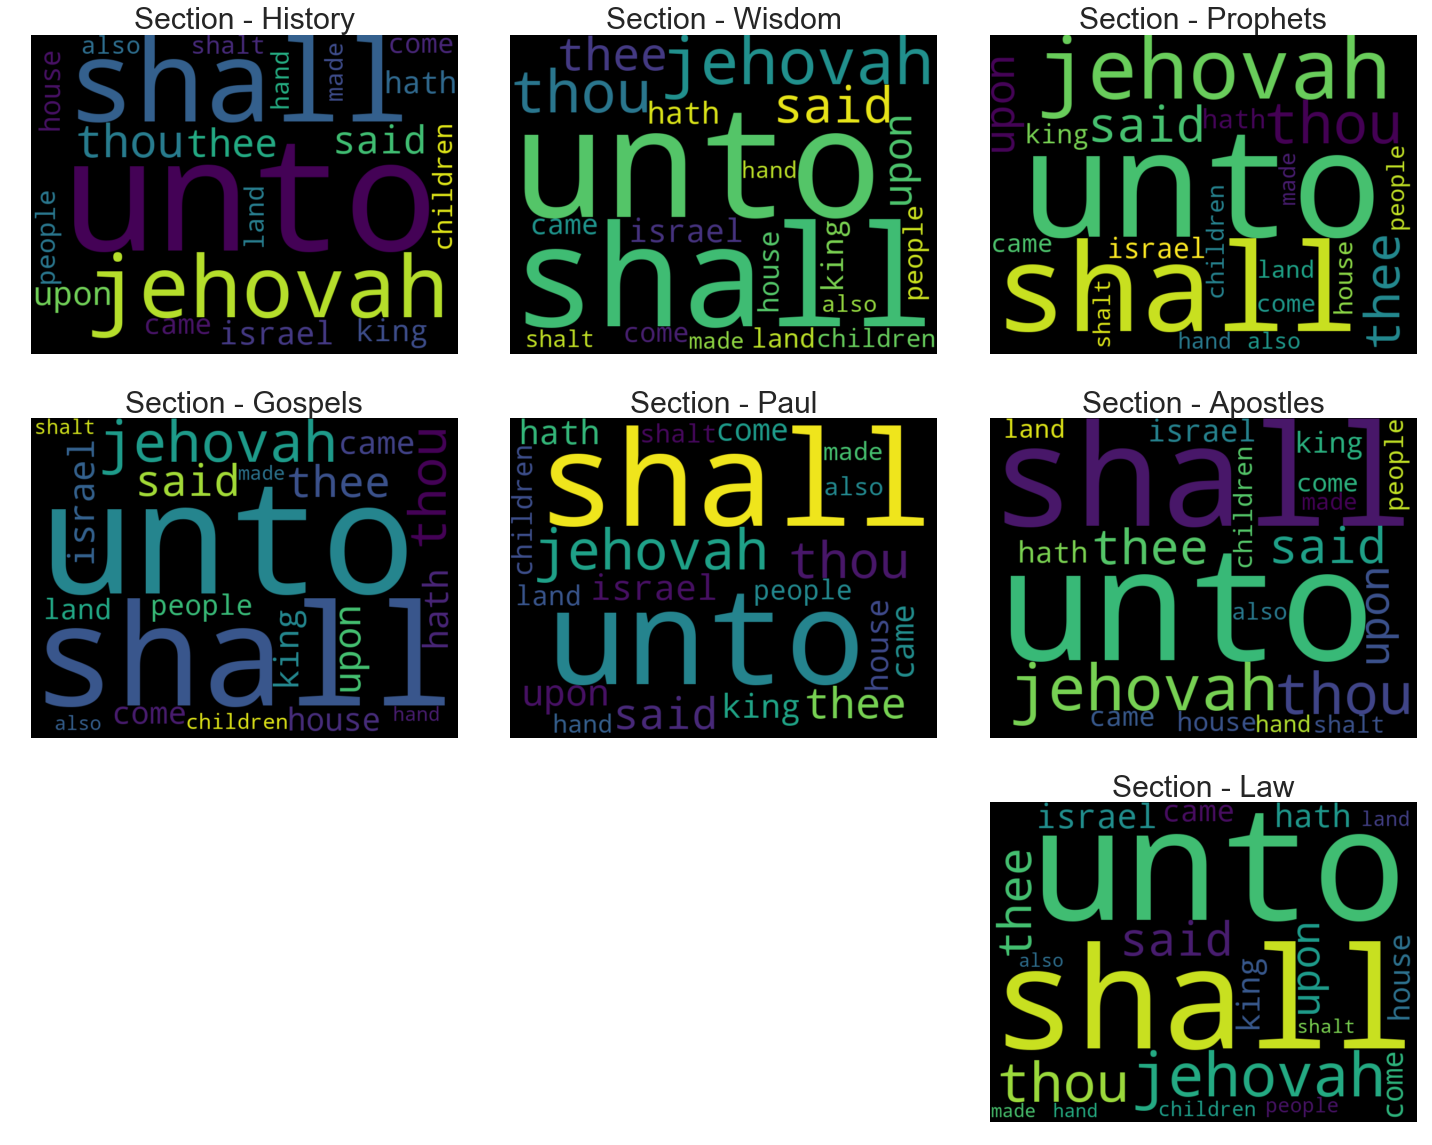

In [20]:
from nltk import sent_tokenize, word_tokenize, regexp_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups

#!pip install wordcloud
books = bible.Books.unique()
sections = bible.Sections.unique()

from wordcloud import WordCloud, STOPWORDS
def tokenize(text, pat='(?u)\\b\\w\\w+\\b', stop_words='english', min_len=2):
    if stop_words:
        stop = set(stopwords.words(stop_words))
    return [w
            for w in regexp_tokenize(text.casefold(), pat)
            if w not in stop and len(w) >= min_len]

count = 1
plt.figure(figsize=(25,20))
for i in range(len(sections)):
    X = X_train.loc[X_train['Sections']==sections[i]]
    X = X_train['text']
    words = tokenize(X.str.cat(sep=' '), min_len=4)
    fdist = FreqDist(words)

    n = '33{:}'.format(i)
    plt.subplot(n)
    wc = WordCloud(width=800, height=600, max_words=20).generate_from_frequencies(fdist)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Section - {:}'.format(sections[i]),size = 30)
    plt.subplots_adjust(wspace=.1)
    count = count + 1
plt.show()

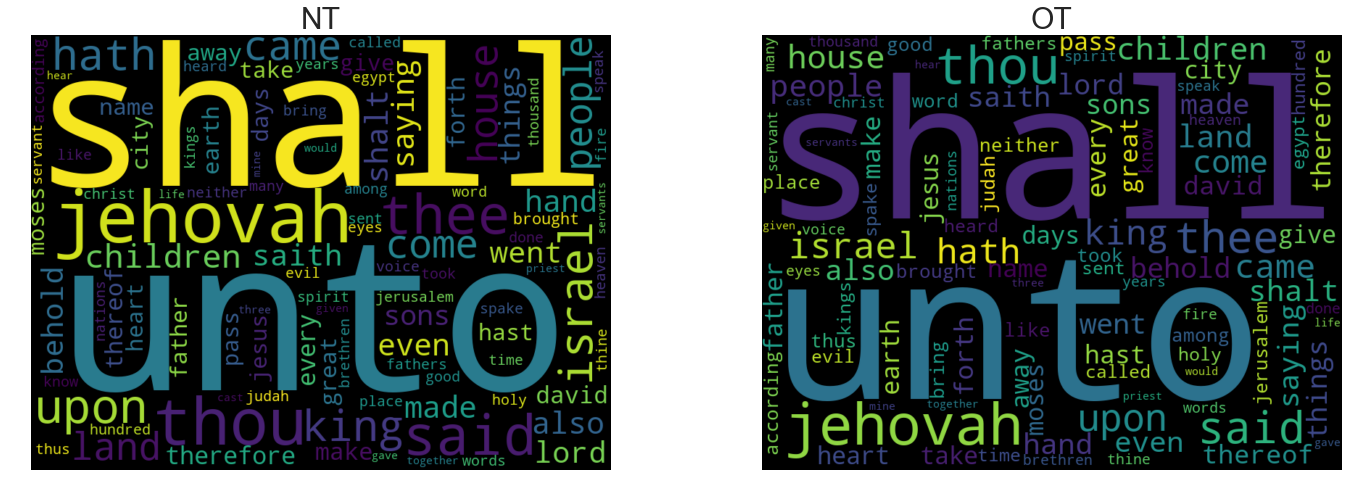

In [21]:
from nltk import sent_tokenize, word_tokenize, regexp_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

def tokenize(text, pat='(?u)\\b\\w\\w+\\b', stop_words='english', min_len=2):
    if stop_words:
        stop = set(stopwords.words(stop_words))
    return [w
            for w in regexp_tokenize(text.casefold(), pat)
            if w not in stop and len(w) >= min_len]

testaments = bible.Testaments.unique()
#X = X_train.loc[X_train[]=='Law']
#print(X)
count = 1
plt.figure(figsize=(25,8))
for i in range(len(testaments)):
    X = X_train.loc[X_train['Testaments']==testaments[i]]
    X = X_train['text']
    words = tokenize(X.str.cat(sep=' '), min_len=4)
    fdist = FreqDist(words)

    n = '12{:}'.format(i)
    plt.subplot(n)
    wc = WordCloud(width=800, height=600, max_words=100).generate_from_frequencies(fdist)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('{:}'.format(testaments[i]),size = 30)
    plt.subplots_adjust(wspace=.1)
    count = count + 1
plt.show()

# Seriation

In [102]:
from scipy.spatial.distance import pdist, squareform
#!pip install fastcluster
from sklearn import datasets
from fastcluster import linkage

In [103]:
def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [ ]:
# Original Data Order
N = len(X_pca)
X = X_pca[np.random.permutation(N),:]
dist_mat = squareform(pdist(X))

plt.pcolormesh(dist_mat)
plt.colorbar()
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

In [ ]:
methods = ["ward","average","single","complete"]
fig, axes = plt.subplots(1, len(methods), figsize=(25, 5))
for i in range(len(methods)):
    ax =axes[i]
    ax.set_title("Method: {:}".format(methods[i]))
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat,methods[i])
    ax.pcolormesh(ordered_dist_mat)
    ax.set_xlim([0,N])
    ax.set_ylim([0,N])

plt.show()

# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward, average, single, complete
linkage_array1 = ward(data)
linkage_array2 = average(data)
linkage_array3 = single(data)
linkage_array4 = complete(data)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters

fig, axes = plt.subplots(1, 4, figsize=(23, 5))
dendrogram(linkage_array1,ax=axes[0])
# mark the cuts in the tree that signify two or three clusters
ax=axes[0]
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [15, 15], '--', c='k')
ax.plot(bounds, [8, 8], '--', c='k')
axes[0].set_ylabel("Cluster distance")
axes[0].set_title('Linkage = Ward')
#ax.set_text(bounds[1], 15, ' three clusters', va='center', fontdict={'size': 15})
#ax.set_text(bounds[1], 8, ' six clusters', va='center', fontdict={'size': 15})

dendrogram(linkage_array2,ax=axes[1])
ax1=axes[1]
# mark the cuts in the tree that signify two or three clusters
ax1 = plt.gca()
axes[1].set_title("Linkage = Avg")
#ax.text(bounds[1], 20, ' three clusters', va='center', fontdict={'size': 15})
#ax.text(bounds[1], 10, ' five clusters', va='center', fontdict={'size': 15})

dendrogram(linkage_array3,ax=axes[2])
ax2=axes[2]
# mark the cuts in the tree that signify two or three clusters
ax2 = plt.gca()
axes[2].set_title('Linkage = Single')
#ax.text(bounds[1], 20, ' three clusters', va='center', fontdict={'size': 15})
#ax.text(bounds[1], 10, ' five clusters', va='center', fontdict={'size': 15})

dendrogram(linkage_array4,ax=axes[3])
ax2=axes[2]
# mark the cuts in the tree that signify two or three clusters
ax2 = plt.gca()
bounds = ax.get_xbound()
b1, b2 = 60,35
ax2.plot(bounds, [b1, b1], '--', c='k')
ax2.plot(bounds, [b2, b2], '--', c='k')
axes[3].set_title('Linkage = Complete')
#axes[3].text(bounds[1], b1, ' 4 clusters', va='center', fontdict={'size': 15})
#axes[3].text(bounds[1], b2, ' 7 clusters', va='center', fontdict={'size': 15})
plt.show()